### 데이터 전처리?
- 일단은 약 3000개의 번역된 문장들로 seq2seq 방식의 모델을 만들어 보려고 함.
- frame work: Pytorch


In [1]:
import re
import os
import unicodedata
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optima
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchinfo import summary

In [2]:
# 그걸 안 불렀다... 
import string
import spacy
import soynlp
import konlpy
from konlpy.tag import Okt

ko_model = 'ko_core_news_sm'
ko_spacy = spacy.load(ko_model)
ko_okt = Okt()
ko_soynlp = soynlp.word.WordExtractor()
punct = string.punctuation

In [61]:
DATA_PATH = './data/translate_ko.txt'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

num_data = 9000     # 데이터 전처리가 너무 오래 걸려서.. ㅠㅜ

In [62]:
# 전처리 함수
# 한국어이고 유니코드는 최대한 지운 상태.
# 악센트 없고 단어사이에 구두점은 많음.
# 필요없는 공백은 거의 없을 것인디... 아마..

def sent_prepro(sent):
    # 공백을 먼저 주면... 
    # 구두점.. 공백을 넣어야하는데..
    sent = re.sub(r'([.!?,"])', r' \1', sent)
    sent = re.sub(r"([':])", r" \1", sent)
    
    # 한국어만 남길 수는 없으니...
    # 음.. 어카지?
    sent = re.sub(r"'", r'"', sent) # 다음 모델은 이렇게 전처리 해보자
    sent = re.sub(r'[^a-zA-Z0-9ㄱ-ㅎ가-힣!.?,"]+', r" ", sent) # 영어를 일부 포함해야한다...
    # sent = re.sub(r'[^0-9ㄱ-ㅎ가-힣!.?,"]+', r" ", sent)
    
    # 공백 문제를 해결해보려는 시도
    sent = re.sub(r"\s+", " ", sent)
    
    return sent

In [63]:
# 너무 느려서 generater가 필요...
def nlp_tokenize(data, nlp_type='None'):
    # 토큰을 담을 그릇
    word_list = []
    
    if nlp_type == 'None':
        pass
    
    elif nlp_type == ko_spacy:
        for sent in data:
            doc = ko_spacy(sent)
            token_list = []
            for token in doc:
                token_list.extend(token)
        # yield token_list
    
    elif nlp_type == ko_okt:
        for sent in data:
            morphs = ko_okt.morphs(sent)
            # carry = []
            # for word in morphs:
            #     carry.append(morphs)
            # word_list.append(carry)
            word_list.extend(morphs)
        # yield word_list
            
    elif nlp_type == ko_soynlp:
        for sent in data:
            ko_soynlp.train(sent)
            for sent in sent:
                result = ko_soynlp.extract()
                score = {w:s.cohesion_forward for w, s in result.items()}
                tokenizer = soynlp.tokenizer.LTokenizer(score)
                carry = []
                for word in tokenizer.tokenize(sent):
                    carry.extend(word)
                word_list.extend(carry)
        
    yield word_list

In [64]:
# 데이터를 빠르께 빠르게 빼줄 generater를 만들고 싶은디..
def data_load(data, i):
    data_ = []
    for k in range(4):
        data_.append(data.readline())
    idx = data_[0]
    first = data_[1]
    second = data_[2]
    skip = data_[3]
    yield idx, first, second, skip

In [65]:
# 파일 데이터를 가져오는 함수
def load_data(data_path, nlp_type=None):
    #  dict 형태면 좀 편할까?
    data_dict = {'index':[], 'first_sent':[], 'second_sent':[],
                 'encoder_in':[], 'decoder_in':[], 'decoder_target':[]}
    
    with open(data_path, mode='r', encoding='utf-8') as f:
        form = """
        [index] - 1
        XXXX
        XXXX
        
        """
        
        for i in range(num_data+1):
        
            # form의 형태처럼 생겼으니 음...
            for carry in data_load(data=f, i=i):
                idx, first, second, skip = carry[0], carry[1], carry[2], carry[3]
                
                # print(f"index: {idx}")
                # print(f"first sent: {first}")
                # print(f"second sent: {second}")
                # print(f"skip: {skip}")
                
                # 문장 전처리
                first = sent_prepro(first)
                second = sent_prepro(second)
                
                # print(f"first sent: {first}")
                # print(f"second sent: {second}")

                # NLP 토큰화 적용 (한 문장이 하나의 리스트로 유지되도록 설정)
                if nlp_type == ko_spacy:
                    first = [token for token in nlp_tokenize([first], nlp_type=ko_spacy)]
                    second = [token for token in nlp_tokenize([second], nlp_type=ko_spacy)]
                    
                elif nlp_type == ko_okt:
                    first = [ko_okt.morphs(first)]
                    second = [ko_okt.morphs(second)]
                
                elif nlp_type == ko_soynlp:
                    first = [token for token in nlp_tokenize([first], nlp_type=ko_soynlp)]
                    second = [token for token in nlp_tokenize([second], nlp_type=ko_soynlp)]
                
                # 토큰 리스트에 시작/끝 토큰 추가
                if nlp_type is None:
                    # None 타입의 경우 문자열로 유지
                    second_in = ["<sos>"] + second.split()
                    second_out = second.split() + ["<eos>"]
                    first_in = first.split()
                else:
                    # NLP 토큰화된 경우 리스트로 유지
                    second_in = ["<sos>"] + second[0]  # 리스트 내부 리스트로 유지
                    second_out = second[0] + ["<eos>"]
                    first_in = first[0]
            
                # dict에 넣어버리기
                data_dict['index'].append(idx)
                data_dict['first_sent'].append(first)
                data_dict['second_sent'].append(second)
                data_dict['encoder_in'].append(first_in)
                data_dict['decoder_in'].append(second_in)
                data_dict['decoder_target'].append(second_out)
                
        return data_dict

In [66]:
# 테스트
first = '그는 오늘도 나에게 상냥하게 항상 "잘 다녀와."라고 웃어준다.'
second = "그는 '머리'만 남아있지만...."

print(f"전처리 전 첫번째 문장: {first}")
print(f"전처리 후 첫번째 문장: {sent_prepro(first)}")
print(f"전처리 전 두번째 문장: {second}")
print(f"전처리 후 두번째 문장: {sent_prepro(second)}")

전처리 전 첫번째 문장: 그는 오늘도 나에게 상냥하게 항상 "잘 다녀와."라고 웃어준다.
전처리 후 첫번째 문장: 그는 오늘도 나에게 상냥하게 항상 "잘 다녀와 . "라고 웃어준다 .
전처리 전 두번째 문장: 그는 '머리'만 남아있지만....
전처리 후 두번째 문장: 그는 "머리 "만 남아있지만 . . . .


In [67]:
carry1, carry2 = [], []
for c in nlp_tokenize(first, nlp_type=ko_okt):
    carry1.extend(c)
for c in nlp_tokenize(second, nlp_type=ko_okt):
    carry2.extend(c)
first = carry1
second = carry2

print(f"tokenize: {first}")
print(f"tokenize: {second}")

tokenize: ['그', '는', '오', '늘', '도', '나', '에', '게', '상', '냥', '하', '게', '항', '상', '"', '잘', '다', '녀', '와', '.', '"', '라', '고', '웃', '어', '준', '다', '.']
tokenize: ['그', '는', "'", '머', '리', "'", '만', '남', '아', '있', '지', '만', '.', '.', '.', '.']


In [68]:
sentence = "그는 오늘도 나에게 상냥하게 항상 '잘 다녀와.'라고 웃어준다."
words = sentence.split()  # 띄어쓰기 단위로 분리

# 각 단어에 morphs 적용
tokens = [ko_okt.morphs(word) for word in words]
print(tokens)

[['그', '는'], ['오늘', '도'], ['나', '에게'], ['상냥하게'], ['항상'], ["'", '잘'], ['다녀와', ".'", '라고'], ['웃어', '준다', '.']]


In [69]:
data_dict = load_data(DATA_PATH, nlp_type=ko_okt)

In [70]:
len(data_dict['decoder_in'])

9001

In [71]:
print(f"data: {data_dict['first_sent'][:5]}")
print(f"data: {data_dict['second_sent'][:5]}")
print()

print(f"인코더 입력: {data_dict['encoder_in'][:5]}")
print(f"디코더 입력: {data_dict['decoder_in'][:5]}")
print(f"디코더 레이블: {data_dict['decoder_target'][:5]}")

data: [[['"', '몸', '의', '어떤', '부분', '도', '공기', '에', '노출', '시키지', '마세요', '.', '"']], [['가끔', '그', '가', '다치고', '피', '범벅', '이', '되어', '도움', '을', '요청', '하던', '모습', '이', '생각납니다', '.']], [['나', '는', '아파트', '건물', '3', '층', '에서', '혼자', '살', '고', '있습니다', '.']], [['비', '가', '내리는', '소리', '를', '듣고', '창문', '을', '보러', '갔습니다', '.']], [['가끔', '내', '뇌', '가', '나를', '속', '여서', '눈', '의', '모서리', '에서', '무언가', '움직이는', '것', '을', '보았다고', '생각', '하게', '만드나', '요', '?']]]
data: [[['"', '다시', '말', '하', '지만', '.', '.', '이건', '훈련', '이', '아니에요', '.', '.', '"']], [['유일한', '후회', '는', '그', '가', '죽었는지', '확인', '하지', '않았다는', '것', '입니다', '.']], [['그런데', '매일', '밤', '내', '가', '자고', '있을', '때', '누가', '내', '창문', '을', '여', '는', '걸까', '요', '?']], [['내', '창문', '은', '젖어', '있지', '않았지만', ',', '유리', '는', '손', '자국', '으로', '덮여', '있었습니다', '.']], [['오늘', '그런', '것', '중', '하나', '를', '목격', '했습니다', '.']]]

인코더 입력: [['"', '몸', '의', '어떤', '부분', '도', '공기', '에', '노출', '시키지', '마세요', '.', '"'], ['가끔', '그', '가', '다치고', '피', '범벅', '이', '되어', '도움', '을',

In [72]:
data_df = pd.DataFrame(data_dict)
data_df.head(3)

,index,first_sent,second_sent,encoder_in,decoder_in,decoder_target
0,[index] - 1\n,"[["", 몸, 의, 어떤, 부분, 도, 공기, 에, 노출, 시키지, 마세요, ., ""]]","[["", 다시, 말, 하, 지만, ., ., 이건, 훈련, 이, 아니에요, ., ....","["", 몸, 의, 어떤, 부분, 도, 공기, 에, 노출, 시키지, 마세요, ., ""]","[<sos>, "", 다시, 말, 하, 지만, ., ., 이건, 훈련, 이, 아니에요...","["", 다시, 말, 하, 지만, ., ., 이건, 훈련, 이, 아니에요, ., .,..."
1,[index] - 2\n,"[[가끔, 그, 가, 다치고, 피, 범벅, 이, 되어, 도움, 을, 요청, 하던, ...","[[유일한, 후회, 는, 그, 가, 죽었는지, 확인, 하지, 않았다는, 것, 입니다...","[가끔, 그, 가, 다치고, 피, 범벅, 이, 되어, 도움, 을, 요청, 하던, 모...","[<sos>, 유일한, 후회, 는, 그, 가, 죽었는지, 확인, 하지, 않았다는, ...","[유일한, 후회, 는, 그, 가, 죽었는지, 확인, 하지, 않았다는, 것, 입니다,..."
2,[index] - 3\n,"[[나, 는, 아파트, 건물, 3, 층, 에서, 혼자, 살, 고, 있습니다, .]]","[[그런데, 매일, 밤, 내, 가, 자고, 있을, 때, 누가, 내, 창문, 을, 여...","[나, 는, 아파트, 건물, 3, 층, 에서, 혼자, 살, 고, 있습니다, .]","[<sos>, 그런데, 매일, 밤, 내, 가, 자고, 있을, 때, 누가, 내, 창문...","[그런데, 매일, 밤, 내, 가, 자고, 있을, 때, 누가, 내, 창문, 을, 여,..."


In [73]:
for _ in data_df['encoder_in']:
    for __ in _:
        print(__)
    print()

"
몸
의
어떤
부분
도
공기
에
노출
시키지
마세요
.
"

가끔
그
가
다치고
피
범벅
이
되어
도움
을
요청
하던
모습
이
생각납니다
.

나
는
아파트
건물
3
층
에서
혼자
살
고
있습니다
.

비
가
내리는
소리
를
듣고
창문
을
보러
갔습니다
.

가끔
내
뇌
가
나를
속
여서
눈
의
모서리
에서
무언가
움직이는
것
을
보았다고
생각
하게
만드나
요
?

자신
의
무덤
을
바라보는
것
은
이상한
기분
입니다
.
.
.

나
는
밤
에
숲속
의
작은
오두막
주위
의
어둠
에서
나오는
이상한
소음
에
익숙해졌습니다
.

아버지
가
돌아가셨을
때
,
우리
는
그
를
화장
하기로
했습니다
.

여름날
꽃밭
에
앉아
있는
그
의
여자친구
에게
다시
물었습니다
.

자신
이
전능하다고
확신
하는
자아도취
적
인
폭
군
은
모두
가
의심
없이
그
를
믿도록
했습니다
.

부검
실
에서
가져온
시신
은
그녀
의
것
이
아니었습니다
.

가끔
뉴스
에서
부당하게
유죄
판결
을
받은
범죄
를
저지르지
않은
사람
의
이야기
를
듣습니다
.

밤
에
내
문
을
계속
두드리는
여자
에게
.

나
는
내
딸
이
남동생
과
놀고
있는
모습
을
보고
얼굴
을
찌푸렸습니다
.
.
.

좀비
는
존재
하지
않습니다
.

나
는
미치지
않았습니다
.

의사
들
이
오늘
전원
을
끌
지
논의
했습니다
.

그
는
눈
을
감고
바람
이
그
의
얼굴
을
스치는
것
을
느꼈습니다
.

무엇
이
더
무섭습니까
?

확실히
하기
위해
나
는
완벽하게
가만히
있었습니다
.

울음소리
가
점점
커져서
귀
를
막고
소리
를
차단
하려고
했습니다
.

거울
을
바라보며
내
얼굴
이
제대로
보이지
않는다는
생각
만
했습니다
.

모두
가
핑거스
위
가
놀랍다고
생각
하지만
나
는
그
매력
을
이해
하지
못
하겠습니다
.

"
레그
데이
준비
됐어
?
어제
의
팔
날
이
힘든
운동
이었지만
,
우리
는
일정
이
있어
.
"

누군가
내
뒤
에
있다고
느낄
때
목덜미
를
타고
오는
그
기분
이
너무
좋아

In [74]:

# 단어사전 생성... 아 import 잊음
# 그래서 import 하고 왔지요

# 단어 사전읋 만드는 함수
# 형태소 문석기 별로 단어사전을 다르게 만들어야 하나...

def bulid_vocab(data, nlp_type='None'):
    # 토큰을 담을 그릇
    word_list = []
    
    
    for sent in data:
        for word in sent:
            word_list.append(word)
   
    
    # print(word_list, '\n')         
    word_counts = Counter(word_list)
    sorted_word = sorted(word_counts, key=word_counts.get, reverse=True)
    
    vocab = {}
    vocab['<PAD>'] = 0
    vocab['<OOV>'] = 1
    
    for idx, word in enumerate(sorted_word):
        vocab[word] = idx+2
    
    return vocab

In [75]:
fs_vocab_none = bulid_vocab(data_df['encoder_in'])
print(f"none vocab len: {len(fs_vocab_none)}")

none vocab len: 12108


In [76]:
with open('./fs_vocab_none.pkl', mode='wb') as f:
    pickle.dump(fs_vocab_none, f)

In [77]:
ss_vocab_none = bulid_vocab(data_df['decoder_in']+data_df['decoder_target'])
print(f"none vocab len: {len(ss_vocab_none)}")

none vocab len: 13643


In [78]:
with open('./ss_vocab_none.pkl', mode='wb') as f:
    pickle.dump(ss_vocab_none, f)

In [79]:
# 문장 생성에 활용할 정수기반 단어 추출 데이터 셋
index_fs_vocab = {v:k for k, v in fs_vocab_none.items()}
index_ss_vocab = {v:k for k, v in ss_vocab_none.items()}

with open('./index_fs_vocab.pkl', mode='wb') as f:
    pickle.dump(index_fs_vocab, f)
with open('./index_ss_vocab.pkl', mode='wb') as f:
    pickle.dump(index_ss_vocab, f)

In [80]:
def text_to_sequences(sents, vocab):
    encoded_X_data = []
    for sent in tqdm(sents):
        idx_seq = []
        for word in sent:
            try:
                idx_seq.append(vocab[word])
            except:
                idx_seq.append(vocab['<OOV>'])
        encoded_X_data.append(idx_seq)
    return encoded_X_data

In [81]:
encoder_input = text_to_sequences(data_dict['encoder_in'], fs_vocab_none)
decoder_input = text_to_sequences(data_dict['decoder_in'], ss_vocab_none)
decoder_target = text_to_sequences(data_dict['decoder_target'], ss_vocab_none)

100%|██████████| 9001/9001 [00:00<00:00, 310412.02it/s]


In [82]:
# test
for i, (item1, item2) in zip(range(5), zip(data_dict['encoder_in'], encoder_input)):
    print(f"Index: {i+1}\nbefore encoding: {item1}\nafter encoding: {item2}\n")

Index: 1
before encoding: ['"', '몸', '의', '어떤', '부분', '도', '공기', '에', '노출', '시키지', '마세요', '.', '"']
after encoding: [14, 122, 15, 222, 794, 60, 678, 10, 1635, 2589, 521, 3, 14]

Index: 2
before encoding: ['가끔', '그', '가', '다치고', '피', '범벅', '이', '되어', '도움', '을', '요청', '하던', '모습', '이', '생각납니다', '.']
after encoding: [254, 12, 7, 2590, 160, 1196, 8, 199, 679, 5, 429, 476, 86, 8, 1636, 3]

Index: 3
before encoding: ['나', '는', '아파트', '건물', '3', '층', '에서', '혼자', '살', '고', '있습니다', '.']
after encoding: [6, 4, 945, 1637, 795, 522, 17, 91, 133, 36, 523, 3]

Index: 4
before encoding: ['비', '가', '내리는', '소리', '를', '듣고', '창문', '을', '보러', '갔습니다', '.']
after encoding: [288, 7, 946, 33, 11, 180, 102, 5, 1638, 2591, 3]

Index: 5
before encoding: ['가끔', '내', '뇌', '가', '나를', '속', '여서', '눈', '의', '모서리', '에서', '무언가', '움직이는', '것', '을', '보았다고', '생각', '하게', '만드나', '요', '?']
after encoding: [254, 9, 524, 7, 21, 37, 1639, 56, 15, 1640, 17, 103, 592, 18, 5, 2592, 39, 270, 2593, 361, 42]



In [83]:
# 이제 패딩...
def padding(sents, max_length=None):
    # 최대 길이 값이 주어지지 않을 경우 데이터 내 최대 길이로 패딩
    if max_length is None:
        max_length = max([len(sent) for sent in sents])
        
    features = np.zeros((len(sents), max_length), dtype=int)
    for idx, sent in enumerate(sents):
        if len(sent) != 0:
            features[idx, :len(sent)] = np.array(sent)[:max_length]
    return features

In [84]:
encoder_input_pad = padding(encoder_input)
decoder_input_pad = padding(decoder_input)
decoder_target_pad = padding(decoder_target)

In [85]:
print(f"encoder shape: {encoder_input_pad.shape}")
print(f"decoder shape: {decoder_input_pad.shape}")
print(f"decoder target shape: {decoder_target_pad.shape}")

encoder shape: (9001, 45)
decoder shape: (9001, 51)
decoder target shape: (9001, 51)


- 이제 데이터 나누고 학습에 들어갈거얌

In [86]:
random_idx = np.arange(encoder_input_pad.shape[0])
np.random.shuffle(random_idx)
print(f"너무 적고 초라한 내 데이터 ㅠㅜ: {random_idx}")

너무 적고 초라한 내 데이터 ㅠㅜ: [ 694 2039 8727 ... 1115 1964 4158]


In [87]:
encoder_input_pad[2564]

array([ 22,   4,  21, 155,  23,  16,   3,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0])

In [88]:
encoder_input[2564]

[22, 4, 21, 155, 23, 16, 3]

In [89]:
data_dict['encoder_in'][2564]

['그녀', '는', '나를', '바라보며', '말', '했다', '.']

In [90]:
encoder_input_ran = encoder_input_pad[random_idx]
decoder_input_ran = decoder_input_pad[random_idx]
decoder_target_ran = decoder_target_pad[random_idx]

# 임의의 번호로
print([index_fs_vocab[word] for word in encoder_input_ran[2564]])
print([index_ss_vocab[word] for word in decoder_input_ran[2564]])
print([index_ss_vocab[word] for word in decoder_target_ran[2564]])

['index', '5356', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<sos>', '평소', '처럼', '잠자리', '에', '들었지만', ',', '깨고', '보니', '심한', '두통', '과', '함께', '낡은', '나무', '배', '위', ',', '끝없는', '바다', '한가운데', '있었다', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['평소', '처럼', '잠자리', '에', '들었지만', ',', '깨고', '보니', '심한', '두통', '과', '함께', '낡은', '나무', '배', '위', ',', '끝없는', '바다', '한가운데', '있었다', '.', '<eos>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD

In [91]:
# 0.1% 검증용? test? 용으로
num_val = int((num_data+1)*0.1)
print(f"data size: {num_val}")

data size: 900


In [92]:
# train data
encoder_input_train = encoder_input_ran[:-num_val]
decoder_input_train = decoder_input_ran[:-num_val]
decoder_target_train = decoder_target_ran[:-num_val]

# test data
encoder_input_test = encoder_input_pad[-num_val:]
decoder_input_test = decoder_input_ran[-num_val:]
decoder_target_test = decoder_target_ran[-num_val:]

In [93]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print()
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (8101, 45)
훈련 target 데이터의 크기 : (8101, 51)
훈련 target 레이블의 크기 : (8101, 51)

테스트 source 데이터의 크기 : (900, 45)
테스트 target 데이터의 크기 : (900, 51)
테스트 target 레이블의 크기 : (900, 51)


In [94]:
# encoder class
class Encoder(nn.Module):
    def __init__(self, fs_vocab_size, embedding_dim, hidden_units):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(fs_vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True)
        
    def forward(self, x):
        y = self.embedding(x)
        _, (hidden_state, cell_state) = self.lstm(y)
        # 인코더의 출력은 hidden_state, cell_state
        return hidden_state, cell_state

In [95]:
# decoder class
class Decoder(nn.Module):
    def __init__(self, ss_vocab_size, embedding_dim, hidden_units):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(ss_vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True)
        # 여기는 출력층
        self.fc = nn.Linear(hidden_units, ss_vocab_size)
        
    def forward(self, x, hidden_state, cell_state):
        # 인코더의 입력을 받아야 하니까
        y = self.embedding(x)
        
        # 이제 인코더의 결과값을 받음
        output, (hidden, cell) = self.lstm(y, (hidden_state, cell_state))
        output = self.fc(output)
        
        return output, hidden, cell

In [96]:
# model class
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        # model에서는 인코더와 디코더의 결과를 이제 합치는 겨?
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, inputs, target):
        hidden, cell = self.encoder(inputs)
        
        # 3D로 필요한 경우에만 unsqueeze(0) 추가
        if hidden.dim() == 2:
            hidden = hidden.unsqueeze(0)
        if cell.dim() == 2:
            cell = cell.unsqueeze(0)

        # 디코더에 hidden과 cell을 전달
        output, hidden_state, cell_state = self.decoder(target, hidden, cell)
        
        return output

In [97]:
# 손실 계산하는 함수?
# loss와 acurassy 계산하는 함수
def calu(model, data_loader):
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for encoder_inputs, decoder_inputs, decoder_targets in data_loader:
        encoder_inputs = encoder_inputs.to(DEVICE)
        decoder_inputs = decoder_inputs.to(DEVICE)
        decoder_targets = decoder_targets.to(DEVICE)

        outputs = model(encoder_inputs, decoder_inputs)

        # 손실 값 계산
        loss_fn = nn.CrossEntropyLoss(ignore_index=0)
        loss = loss_fn(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
        total_loss += loss.item()  # 손실 값을 숫자 값으로 사용

        # 정확도 계산 (패딩 토큰 제외)
        mask_data = (decoder_targets != 0)
        predictions = outputs.argmax(dim=-1)
        correct_predictions = (predictions == decoder_targets) & mask_data
        total_correct += correct_predictions.sum().item()
        total_samples += mask_data.sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_samples

    return avg_loss, accuracy


In [98]:
def training(model, train_datasets, test_datasets, epochs=100, BATCH_SIZE=64, lr=0.001, patience=10):
    
    loss_dict = {'train':[], 'val':[]}
    acc_dict = {'train':[], 'val':[]}
    
    model = model.to(DEVICE)
    optimizer = optima.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, patience=patience, mode='min')
    train_dl = DataLoader(train_datasets, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(test_datasets, batch_size=10, shuffle=True)
    
    save_model = './model/seq2_test_3_model.pth'
    save_param = './model/seq2_test_3_param.pth'
    
    for epoch in range(1, epochs+1):
        model.train()
        
        for encoder_inputs, decoder_inputs, decoder_targets in train_dl:
            encoder_inputs = encoder_inputs.to(DEVICE)
            decoder_inputs = decoder_inputs.to(DEVICE)
            decoder_targets = decoder_targets.to(DEVICE)

            optimizer.zero_grad()
            
            # 순전파 전파
            outputs = model(encoder_inputs, decoder_inputs)
            
            # loss
            loss = nn.CrossEntropyLoss(ignore_index=0)(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
            loss.backward()
            
            optimizer.step()
            
        train_loss, train_acc = calu(model, train_dl)
        val_loss, val_acc = calu(model, val_dl)
        
        loss_dict['train'].append(train_loss)
        loss_dict['val'].append(val_loss)
        acc_dict['train'].append(train_acc)
        acc_dict['val'].append(val_acc)
    
        if epoch%5 == 0:
                print(f"[{epoch:5}/{epochs:5}]  [Train]         loss: {train_loss:.6f}, score: {train_acc*100:.6f} %")
                print(f"[{epoch:5}/{epochs:5}]  [Validation]    loss: {val_loss:.6f}, score: {val_acc*100:.6f} %\n")
            
        if len(acc_dict['val']) == 1:
            print("saved first")
            torch.save(model.state_dict(), save_param)
            torch.save(model, save_model)
        else:
            if acc_dict['val'][-1] >= max(acc_dict['val']):
                print(f"[{epoch:5}/{epochs:5}] saved model")
                torch.save(model.state_dict(), save_param)
                torch.save(model, save_model)
                    
        scheduler.step(val_loss)
        
        if scheduler.num_bad_epochs >= scheduler.patience:
            print('성능 및 손실의 개선이 없어서 학습을 중단합니다.\n')
            print(f"[{epoch:5}/{epochs:5}]  [Train]         loss: {train_loss:.6f}, score: {train_acc*100:.6f} %")
            print(f"[{epoch:5}/{epochs:5}]  [Validation]    loss: {val_loss:.6f}, score: {val_acc*100:.6f} %\n")
            break

    return loss_dict, acc_dict

In [99]:
def over_training(model, train_datasets, test_datasets, epochs=100, BATCH_SIZE=64, lr=0.001, patience=10):
    
    loss_dict = {'train':[], 'val':[]}
    acc_dict = {'train':[], 'val':[]}
    
    model = model.to(DEVICE)
    optimizer = optima.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, patience=patience, mode='min')
    train_dl = DataLoader(train_datasets, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(test_datasets, batch_size=10, shuffle=True)
    
    save_model = './model/seq2_model.pth'
    save_param = './model/seq2_param.pth'
    
    for epoch in range(1, epochs+1):
        model.train()
        
        for encoder_inputs, decoder_inputs, decoder_targets in train_dl:
            encoder_inputs = encoder_inputs.to(DEVICE)
            decoder_inputs = decoder_inputs.to(DEVICE)
            decoder_targets = decoder_targets.to(DEVICE)

            optimizer.zero_grad()
            
            # 순전파 전파
            outputs = model(encoder_inputs, decoder_inputs)
            
            # loss
            loss = nn.CrossEntropyLoss(ignore_index=0)(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
            loss.backward()
            
            optimizer.step()
            
        train_loss, train_acc = calu(model, train_dl)
        val_loss, val_acc = calu(model, val_dl)
        
        loss_dict['train'].append(train_loss)
        loss_dict['val'].append(val_loss)
        acc_dict['train'].append(train_acc)
        acc_dict['val'].append(val_acc)
    
        if epoch%5 == 0:
                print(f"[{epoch:5}/{epochs:5}]  [Train]         loss: {train_loss:.6f}, score: {train_acc*100:.6f} %")
                print(f"[{epoch:5}/{epochs:5}]  [Validation]    loss: {val_loss:.6f}, score: {val_acc*100:.6f} %\n")
            
        if len(acc_dict['val']) == 1:
            print("saved first")
            torch.save(model.state_dict(), save_param)
            torch.save(model, save_model)
        else:
            if acc_dict['val'][-1] >= max(acc_dict['val']):
                print(f"[{epoch:5}/{epochs:5}] saved model")
                torch.save(model.state_dict(), save_param)
                torch.save(model, save_model)
                    
        scheduler.step(train_loss)
        
        if scheduler.num_bad_epochs >= scheduler.patience:
            print('성능 및 손실의 개선이 없어서 학습을 중단합니다.\n')
            print(f"[{epoch:5}/{epochs:5}]  [Train]         loss: {train_loss:.6f}, score: {train_acc*100:.6f} %")
            print(f"[{epoch:5}/{epochs:5}]  [Validation]    loss: {val_loss:.6f}, score: {val_acc*100:.6f} %\n")
            break

    return loss_dict, acc_dict

In [105]:
fs_vocab_size = len(fs_vocab_none)
ss_vocab_size = len(ss_vocab_none)

# 튜닝할때 같이 손봐야징
embeddong_dim, hidden_units = 128, 128
# embeddong_dim, hidden_units = 256, 256
# embeddong_dim, hidden_units = 64, 128
# embeddong_dim, hidden_units = 64, 64

encoder = Encoder(fs_vocab_size, embeddong_dim, hidden_units)
decoder = Decoder(ss_vocab_size, embeddong_dim, hidden_units)
seq2seq_model = Seq2Seq(encoder, decoder)

In [106]:
print(seq2seq_model)
summary(seq2seq_model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(12108, 128, padding_idx=0)
    (lstm): LSTM(128, 128, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(13643, 128, padding_idx=0)
    (lstm): LSTM(128, 128, batch_first=True)
    (fc): Linear(in_features=128, out_features=13643, bias=True)
  )
)


Layer (type:depth-idx)                   Param #
Seq2Seq                                  --
├─Encoder: 1-1                           --
│    └─Embedding: 2-1                    1,549,824
│    └─LSTM: 2-2                         132,096
├─Decoder: 1-2                           --
│    └─Embedding: 2-3                    1,746,304
│    └─LSTM: 2-4                         132,096
│    └─Linear: 2-5                       1,759,947
Total params: 5,320,267
Trainable params: 5,320,267
Non-trainable params: 0

In [107]:
# tensor
# train
encoder_input_train_ts = torch.tensor(encoder_input_train, dtype=torch.long)
decoder_input_train_ts = torch.tensor(decoder_input_train, dtype=torch.long)
decoder_target_train_ts = torch.tensor(decoder_target_train, dtype=torch.long)

# test
encoder_input_test_ts = torch.tensor(encoder_input_test, dtype=torch.long)
decoder_input_test_ts = torch.tensor(decoder_input_test, dtype=torch.long)
decoder_target_test_ts = torch.tensor(decoder_target_test, dtype=torch.long)

In [108]:
train_datasets = TensorDataset(encoder_input_train_ts, decoder_input_train_ts, decoder_target_train_ts)
test_datasets = TensorDataset(encoder_input_test_ts, decoder_input_test_ts, decoder_target_test_ts)

In [ ]:
batch_size = 64

# normal
loss_dict, acc_dict = training(seq2seq_model, train_datasets, test_datasets)

# over fitting
# loss_dict, acc_dict = over_training(seq2seq_model, train_datasets, test_datasets)

saved first
[    2/  100] saved model
[    3/  100] saved model
[    4/  100] saved model
[    5/  100]  [Train]         loss: 4.749070, score: 26.611777 %
[    5/  100]  [Validation]    loss: 5.217862, score: 25.808340 %

[    5/  100] saved model
[    6/  100] saved model
[    7/  100] saved model
[    8/  100] saved model
[    9/  100] saved model
[   10/  100]  [Train]         loss: 4.128742, score: 31.141627 %
[   10/  100]  [Validation]    loss: 5.015181, score: 28.866046 %

[   10/  100] saved model
[   11/  100] saved model
[   12/  100] saved model
[   13/  100] saved model
[   14/  100] saved model
[   15/  100]  [Train]         loss: 3.681280, score: 34.547742 %
[   15/  100]  [Validation]    loss: 4.991604, score: 29.959014 %

[   15/  100] saved model


In [ ]:
def draw_two_plot(loss, score, title, type_='LSTM'):
    
    # 축을 2개 사용하고 싶음.
    fig, ax1 = plt.subplots(figsize=(7, 7))
    ax2 = ax1.twinx()
    
    ax1.plot(loss['train'], label=f"train loss mean: {sum(loss['train'])/len(loss['train']):.6f}", color='#5587ED')
    ax1.plot(loss['val'], label=f"validation loss mean: {sum(loss['val'])/len(loss['val']):.6f}", color='#F361A6')
    ax2.plot(score['train'], label=f"train score max: {max(score['train'])*100:.2f} %", color='#00007F')
    ax2.plot(score['val'], label=f"validation score max: {max(score['val'])*100:.2f} %", color='#99004C')
    
    fig.suptitle(f'{title} {type_}', fontsize=15)
    ax1.set_ylabel('loss', fontsize=10, color='#5587ED')
    ax2.set_ylabel('score', fontsize=10, color='#00007F')
    
    fig.legend(fontsize='small', loc='lower left')
    # plt.xticks(np.arange(0, len(loss['train']), 2), labels=[x for x in range(1, len(loss['val'])+1, 2)])
    plt.show()

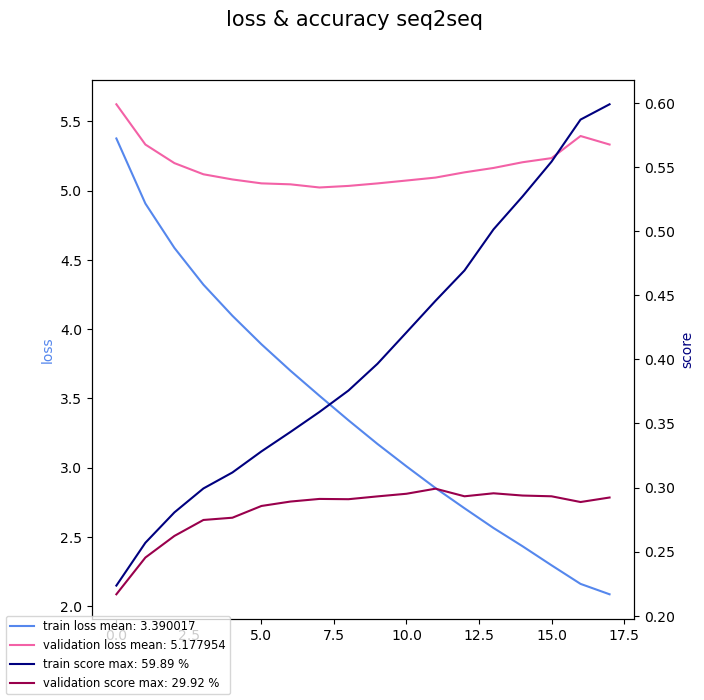

In [ ]:
draw_two_plot(loss_dict, acc_dict, 'loss & accuracy', 'seq2seq')

In [ ]:
test_dl = DataLoader(test_datasets, batch_size=64, shuffle=True)
test_loss, test_acc = calu(seq2seq_model, test_dl)

print(f"test loss: {test_loss:.6f}")
print(f"test_acc: {test_acc*100:.4f} %")


test loss: 5.352470
test_acc: 29.2286 %


In [ ]:
print(ss_vocab_none['<sos>'])
print(ss_vocab_none['<eos>'])

3
4


In [ ]:
# 인코딩을 디코딩!!
def seq_to_enco(input_seq):
    sent = ''
    for enco_word in input_seq:
        if (enco_word != 0):
            sent = sent + index_fs_vocab[enco_word] + ' '
    return sent

def seq_to_deco(input_seq):
    sent =''
    for enco_word in input_seq:
        if(enco_word != 0 and enco_word != ss_vocab_none['<sos>'] and enco_word != ss_vocab_none['<eos>']):
            sent = sent + index_ss_vocab[enco_word] + ' '
    return sent

In [ ]:
print(encoder_input_test[25])
print(decoder_input_test[25])
print(decoder_target_test[25])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
[   3  431   77   12  419   12   34   13  258   14 1068   22    2    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
[ 431   77   12  419   12   34   13  258   14 1068   22    2    4    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


In [ ]:
def decode_sequence(model, input_seq, src_vocab_size, tar_vocab_size, max_output_len, int_to_src_token, int_to_tar_token):
    encoder_inputs = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(DEVICE)

    # 인코더의 초기 상태 설정
    hidden, cell = model.encoder(encoder_inputs)

    # 시작 토큰 <sos>을 디코더의 첫 입력으로 설정
    # unsqueeze(0)는 배치 차원을 추가하기 위함.
    decoder_input = torch.tensor([3], dtype=torch.long).unsqueeze(0).to(DEVICE)

    decoded_tokens = []

    # for문을 도는 것 == 디코더의 각 시점
    for _ in range(max_output_len):
        output, hidden, cell = model.decoder(decoder_input, hidden, cell)

        # 소프트맥스 회귀를 수행. 예측 단어의 인덱스
        output_token = output.argmax(dim=-1).item()

        # 종료 토큰 <eos>
        if output_token == 4:
            break

        # 각 시점의 단어(정수)는 decoded_tokens에 누적하였다가 최종 번역 시퀀스로 리턴
        decoded_tokens.append(output_token)

        # 현재 시점의 예측. 다음 시점의 입력으로 사용된다.
        decoder_input = torch.tensor([output_token], dtype=torch.long).unsqueeze(0).to(DEVICE)

    return ' '.join(int_to_tar_token[token] for token in decoded_tokens)

In [ ]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index]
  translated_text = decode_sequence(seq2seq_model, input_seq, fs_vocab_size, ss_vocab_size, 50, index_fs_vocab, index_ss_vocab)

  print("입력문장 :",seq_to_enco(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_deco(decoder_input_train[seq_index]))
  print("예측문장 :",translated_text)
  print("-"*50)

입력문장 : index 5223 
정답문장 : " 팔이 마비 되었고 , 뇌 활동 도 멈췄습니다 " 라고 만 박사 는 진지하게 말 했다 . 
예측문장 : index
--------------------------------------------------
입력문장 : index 3668 
정답문장 : 나 는 다시 모스크바 의 극장 에서 무용수 로 춤추는 꿈 을 꾸었다 . 
예측문장 : index
--------------------------------------------------
입력문장 : 
정답문장 : index 8539 
예측문장 : index
--------------------------------------------------
입력문장 : 그 는 내 뒤 에서 속삭였다 . 
정답문장 : " 결정 은 네 가 해 . " 
예측문장 : index
--------------------------------------------------
입력문장 : index 3923 
정답문장 : 그녀 의 눈 을 바라보면서 나 는 배 가 아프고 무릎 이 약해지는 것 을 느꼈어 . 
예측문장 : index
--------------------------------------------------


In [ ]:
for seq_index in [3, 50, 124, 300, 230]:
  input_seq = encoder_input_test[seq_index]
  translated_text = decode_sequence(seq2seq_model, input_seq, fs_vocab_size, ss_vocab_size, 50, index_fs_vocab, index_ss_vocab)

  print("입력문장 :",seq_to_enco(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_deco(decoder_input_test[seq_index]))
  print("예측문장 :",translated_text)
  print("-"*50)

입력문장 : 
정답문장 : 그 는 나 에게 불안함을 안겨주었다 . 
예측문장 : index
--------------------------------------------------


입력문장 : 
정답문장 : 의사 가 아내 에게 살 날 이 세 달 밖에 남지 않았다고 말 했다 . 
예측문장 : index
--------------------------------------------------
입력문장 : 
정답문장 : 친구 가 나 에게 유튜브 링크 를 보냈다 . 
예측문장 : index
--------------------------------------------------
입력문장 : 
정답문장 : 내 아들 의 화장 이 내 인생 에서 가장 끔찍한 날이었다 . 
예측문장 : index
--------------------------------------------------
입력문장 : 
정답문장 : index 8622 
예측문장 : index
--------------------------------------------------


In [ ]:
seq2seq_model = torch.load('./model/seq2_test_model.pth', weights_only=False)

print(f"test loss: {test_loss:.6f}")
print(f"test_acc: {test_acc*100:.4f} %")

test loss: 5.352470
test_acc: 29.2286 %


In [ ]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index]
  translated_text = decode_sequence(seq2seq_model, input_seq, fs_vocab_size, ss_vocab_size, 50, index_fs_vocab, index_ss_vocab)

  print("입력문장 :",seq_to_enco(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_deco(decoder_input_train[seq_index]))
  print("예측문장 :",translated_text)
  print("-"*50)

입력문장 : index 5223 
정답문장 : " 팔이 마비 되었고 , 뇌 활동 도 멈췄습니다 " 라고 만 박사 는 진지하게 말 했다 . 
예측문장 : 내 가 내 가 내 가 내 가 내 가 내 가 내 가 카메라 것 을 알 네 .
--------------------------------------------------
입력문장 : index 3668 
정답문장 : 나 는 다시 모스크바 의 극장 에서 무용수 로 춤추는 꿈 을 꾸었다 . 
예측문장 : " 는 내 가 내 가 내 가 내 가 내 가 카메라 사람 알 네 .
--------------------------------------------------
입력문장 : 
정답문장 : index 8539 
예측문장 : 나 는 내 가 " 의 집 을 곧 내 가 내 가 보고 그저 .
--------------------------------------------------
입력문장 : 그 는 내 뒤 에서 속삭였다 . 
정답문장 : " 결정 은 네 가 해 . " 
예측문장 : " 는 내 가 내 가 내 가 내 가 내 가 내 가 카메라 것 을 알 네 .
--------------------------------------------------
입력문장 : index 3923 
정답문장 : 그녀 의 눈 을 바라보면서 나 는 배 가 아프고 무릎 이 약해지는 것 을 느꼈어 . 
예측문장 : " 는 내 가 내 가 내 가 내 가 내 가 내 가 카메라 것 을 알 네 .
--------------------------------------------------


In [ ]:
for seq_index in [3, 50, 101, 300, 230]:
  input_seq = encoder_input_test[seq_index]
  translated_text = decode_sequence(seq2seq_model, input_seq, fs_vocab_size, ss_vocab_size, 50, index_fs_vocab, index_ss_vocab)

  print("입력문장 :",seq_to_enco(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_deco(decoder_input_test[seq_index]))
  print("예측문장 :",translated_text)
  print("-"*50)

입력문장 : 
정답문장 : 그 는 나 에게 불안함을 안겨주었다 . 
예측문장 : 나 는 내 가 " 의 집 을 곧 내 가 내 가 보고 그저 .
--------------------------------------------------
입력문장 : 
정답문장 : 의사 가 아내 에게 살 날 이 세 달 밖에 남지 않았다고 말 했다 . 
예측문장 : 나 는 내 가 " 의 집 을 곧 내 가 내 가 보고 그저 .
--------------------------------------------------
입력문장 : 
정답문장 : 용병 들 이 내 친구 들 을 쏘아 죽였을 때 나 는 비명 을 질렀다 . 
예측문장 : 나 는 내 가 " 의 집 을 곧 내 가 내 가 보고 그저 .
--------------------------------------------------
입력문장 : 
정답문장 : 내 아들 의 화장 이 내 인생 에서 가장 끔찍한 날이었다 . 
예측문장 : 나 는 내 가 " 의 집 을 곧 내 가 내 가 보고 그저 .
--------------------------------------------------
입력문장 : 
정답문장 : index 8622 
예측문장 : 나 는 내 가 " 의 집 을 곧 내 가 내 가 보고 그저 .
--------------------------------------------------


In [ ]:
def decode_sequence_web(model, input_seq, src_vocab_size, tar_vocab_size, max_output_len, int_to_src_token, int_to_tar_token):
     # 1D 배열일 경우 배치 차원을 추가하여 2D로 변환
    if input_seq.dim() == 1:
        encoder_inputs = input_seq.unsqueeze(0).to(DEVICE)
    else:
        encoder_inputs = input_seq.to(DEVICE)

    # 인코더의 초기 상태 설정
    hidden, cell = model.encoder(encoder_inputs)
    # print(f"Encoder hidden state: {hidden}")
    # print(f"Encoder cell state: {cell}")
    
    # hidden, cell의 batch 크기를 맞추기 위해 필요시 squeeze/unsqueeze
    if hidden.size(1) != 1:
        hidden = hidden[:, :1, :]
        cell = cell[:, :1, :]

    # 시작 토큰 <sos>을 디코더의 첫 입력으로 설정
    decoder_input = torch.tensor([3], dtype=torch.long).unsqueeze(0).to(DEVICE)
    # print(f"Decoder initial input (start token): {decoder_input}")

    decoded_tokens = []

    # for문을 도는 것 == 디코더의 각 시점
    for _ in range(max_output_len):
        output, hidden, cell = model.decoder(decoder_input, hidden, cell)

        # 소프트맥스 회귀를 수행. 예측 단어의 인덱스
        output_token = output.argmax(dim=-1).item()

        # 예측된 토큰과 그에 대한 매핑을 출력하여 확인
        # print(f"Predicted token index: {output_token}, Decoded token: {int_to_tar_token.get(output_token, '<OOV>')}")
        
        # 종료 토큰 <eos>
        if output_token == 4:
            break

        # 각 시점의 단어(정수)는 decoded_tokens에 누적하였다가 최종 번역 시퀀스로 리턴
        decoded_tokens.append(output_token)

        # 현재 시점의 예측. 다음 시점의 입력으로 사용된다.
        decoder_input = torch.tensor([output_token], dtype=torch.long).unsqueeze(0).to(DEVICE)

    return ' '.join(int_to_tar_token[token] for token in decoded_tokens)

In [ ]:
text = '어젯밤, 눈싸움이 생각보다 더 어렵다는 걸 알게 됐다.'
real_text = '천장에 있는 눈들이 이기고 있었다.'

enco_in = text_to_sequences([text], fs_vocab_none)
print(enco_in)
enco_pad = padding(enco_in)
print(enco_pad)
enco_in_ts = torch.tensor(enco_pad, dtype=torch.long)
print(enco_in_ts[0])
input_seq = enco_in_ts[0]

translated_text = decode_sequence_web(seq2seq_model, input_seq, fs_vocab_size, ss_vocab_size, 50, index_fs_vocab, index_ss_vocab)

print("\n입력문장 :",text)
print("정답문장 :",real_text)
print("예측문장 :",translated_text)



100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]

[[124, 1, 41, 13, 1, 56, 1, 5259, 8, 1, 1, 1, 1, 120, 1, 53, 1, 124, 1, 120, 4, 1, 70, 1, 90, 82, 1, 1, 120, 3]]
[[ 124    1   41   13    1   56    1 5259    8    1    1    1    1  120
     1   53    1  124    1  120    4    1   70    1   90   82    1    1
   120    3]]
tensor([ 124,    1,   41,   13,    1,   56,    1, 5259,    8,    1,    1,    1,
           1,  120,    1,   53,    1,  124,    1,  120,    4,    1,   70,    1,
          90,   82,    1,    1,  120,    3])

입력문장 : 어젯밤, 눈싸움이 생각보다 더 어렵다는 걸 알게 됐다.
정답문장 : 천장에 있는 눈들이 이기고 있었다.
예측문장 : 
